In [1]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader

In [2]:
GoogleDriveDownloader.download_file_from_google_drive(file_id='1tU_MRukrg3D2iZFZ-tk4oj6MfV4o7q4u',
                                                      dest_path='./rilevazioni.csv', overwrite=True)

In [0]:
import os
import requests
import pandas as pd
import random
import numpy as np

In [4]:
rilevazioni = pd.read_csv('rilevazioni.csv').set_index(['Regione','Citta'])
rilevazioni.iloc[:,-10:]

13-04  14-04  15-04  ...  20-04  21-04  22-04
Regione   Citta                                 ...                     
LOMBARDIA BERGAMO          10391  10426  10472  ...  10738  10788  10848
          BRESCIA          11058  11093  11187  ...  12004  12078  12178
          COMO              2015   2106   2154  ...   2550   2592   2681
          CREMONA           4945   5172   5202  ...   5491   5641   5706
          LECCO             1911   1970   1982  ...   2080   2093   2109
...                          ...    ...    ...  ...    ...    ...    ...
CALABRIA  COSENZA            295    317    318  ...    408    417    426
          REGGIO CALABRIA    263    268    276  ...    243    243    247
          CATANZARO          183    184    190  ...    197    197    197
          VIBO VALENTIA       68     68     68  ...     71     71     71
          CROTONE            117    117    117  ...    117    117    117

[108 rows x 10 columns]

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

def plot_annotate(df, title='', xdelta=0, ydelta=10, figsize=(17, 7)):
  
  ax = df.T.plot(figsize=figsize, title=title)
  ax.set_xticks(ticks=np.arange(0, len(df.columns) , step=2))
  tick_label = list(df.columns)[::2]
  ax.set_xticklabels(tick_label)

  for k, v in zip(np.arange(len(df.columns)), df.T.iterrows()):
    for el in v[1]:
      ax.annotate(el, (k + xdelta, el + ydelta))
  return ax

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sorted_by_infections = rilevazioni.loc[rilevazioni.sort_values(by=[rilevazioni.columns[-1]],ascending=False).index]

In [0]:
crescita = pd.DataFrame(index=sorted_by_infections.index)

In [0]:
for ieri, oggi in zip(sorted_by_infections.columns[:-1], sorted_by_infections.columns[1:]):
  crescita[oggi] = sorted_by_infections[oggi] - sorted_by_infections[ieri]

In [9]:
display(crescita.head(3))
sorted_by_infections.head(3)

09-03  10-03  11-03  12-03  ...  19-04  20-04  21-04  22-04
Regione   Citta                                ...                            
LOMBARDIA MILANO     100     86    333    221  ...    279    287    408    480
          BRESCIA    238     51    561    247  ...    188     58     74    100
PIEMONTE  TORINO      -2     24     48     28  ...    353    134    332    414

[3 rows x 45 columns]

08-03  09-03  10-03  11-03  ...  19-04  20-04  21-04  22-04
Regione   Citta                                ...                            
LOMBARDIA MILANO     406    506    592    925  ...  15825  16112  16520  17000
          BRESCIA    501    739    790   1351  ...  11946  12004  12078  12178
PIEMONTE  TORINO      89     87    111    159  ...  10144  10278  10610  11024

[3 rows x 46 columns]

In [0]:
crescita_italia = crescita.sum().to_frame().T
crescita_italia.index = ['Italia']

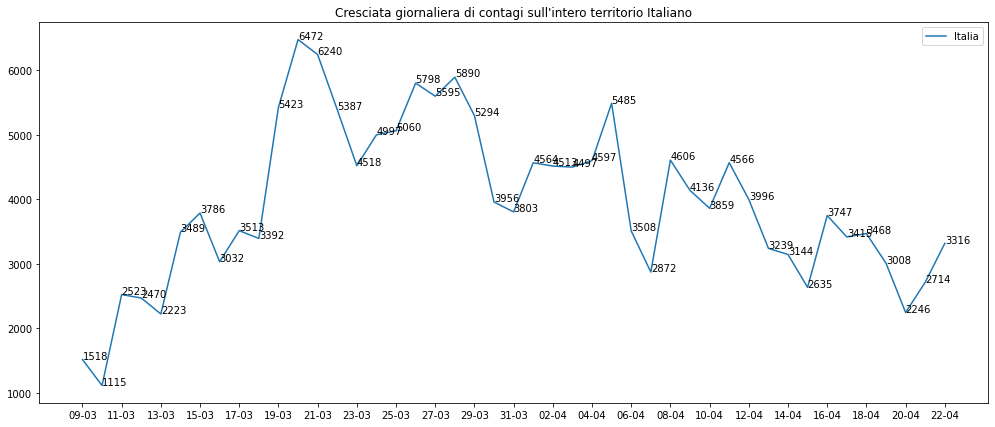

In [11]:
_ = plot_annotate(crescita_italia, 'Cresciata giornaliera di contagi sull\'intero territorio Italiano')

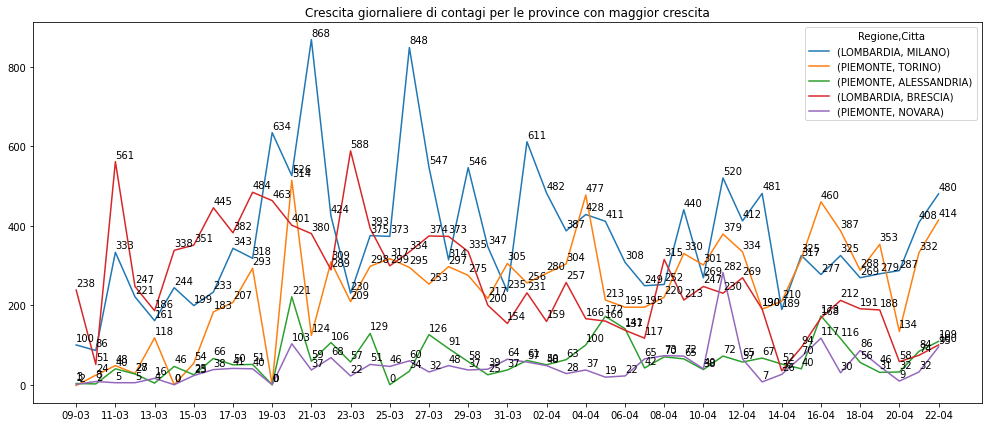

In [12]:
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(5),
                   'Crescita giornaliere di contagi per le province con maggior crescita')
#_ = ax.set_ylim(-111,ax.get_ylim()[1])

# Average 3 days

In [0]:
avg3 = pd.DataFrame(index=crescita.sort_values(by=crescita.columns[-1], ascending=False).index)
for meno2,ieri, oggi in zip(crescita.columns[:-2], crescita.columns[1:-1], crescita.columns[2:]):
  avg3[oggi] = pd.concat([crescita[oggi], crescita[ieri], crescita[meno2]], axis=1).mean(axis=1)

In [0]:
avg3 = avg3.astype('int32')

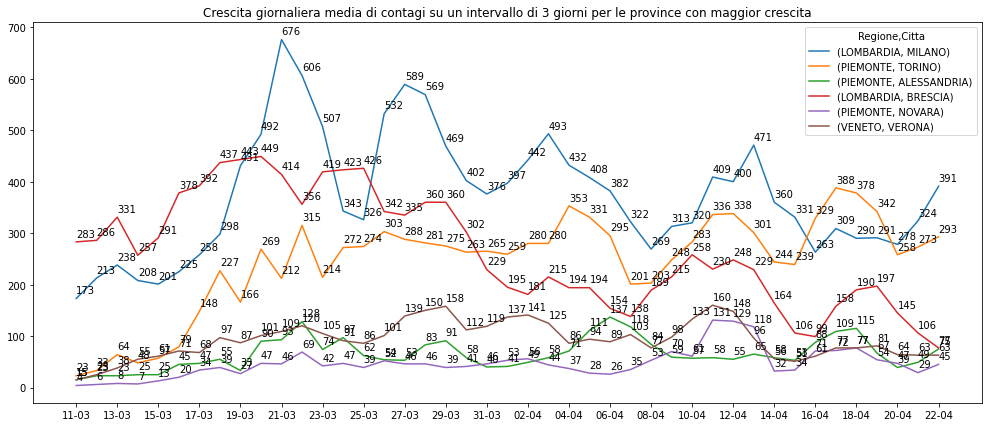

In [15]:
_ = plot_annotate(avg3.head(6), 'Crescita giornaliera media di contagi su un intervallo di 3 giorni per le province con maggior crescita')

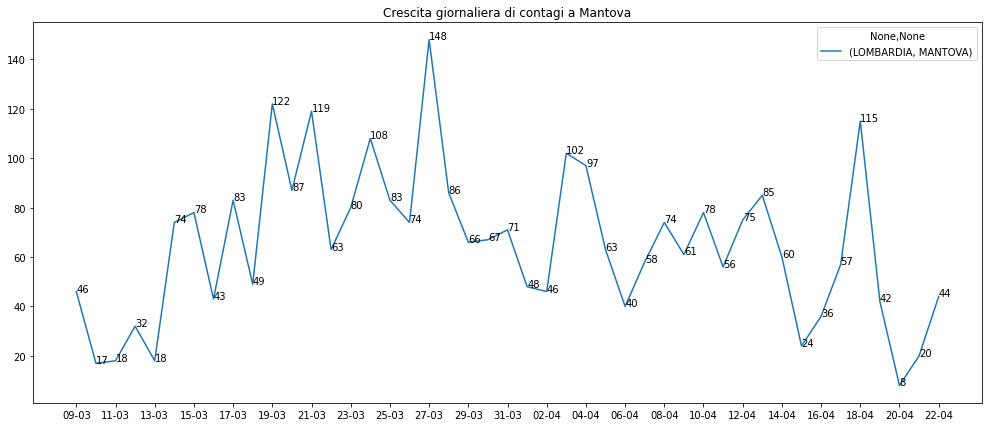

In [16]:
_ = plot_annotate(crescita.loc[('LOMBARDIA','MANTOVA')].to_frame().T, 'Crescita giornaliera di contagi a Mantova', ydelta=0)

In [0]:
regioni = sorted_by_infections.groupby('Regione').sum()
regioni = regioni.sort_values(by=[regioni.columns[-1]],ascending=False)

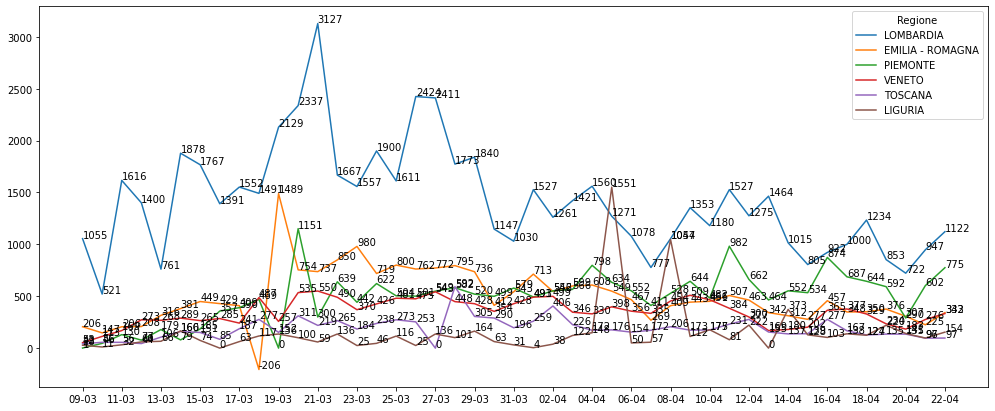

In [18]:
crescita_regioni = crescita.groupby('Regione').sum().loc[regioni.index]
_ = plot_annotate(crescita_regioni.head(6))


In [0]:
casi_italia = sorted_by_infections.sum(axis=0).to_frame().T
casi_italia.index= ['Italia']

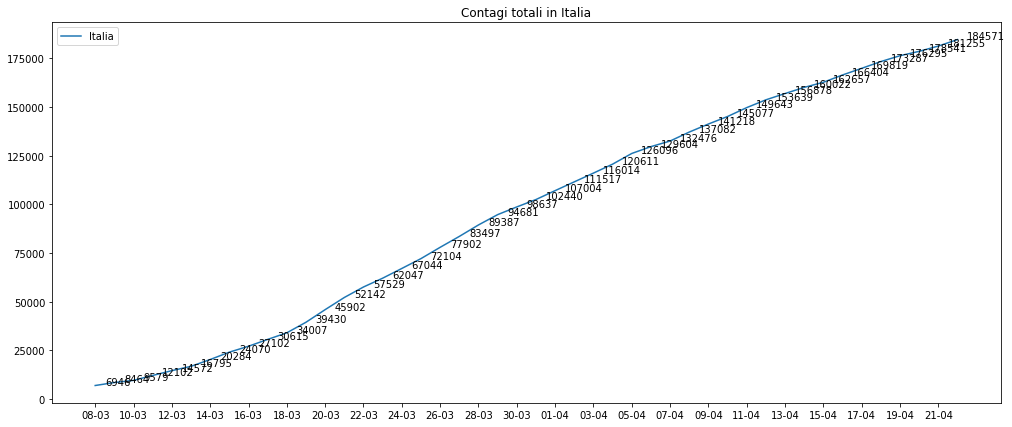

In [20]:
_ = plot_annotate(casi_italia, 'Contagi totali in Italia', xdelta=0.5)

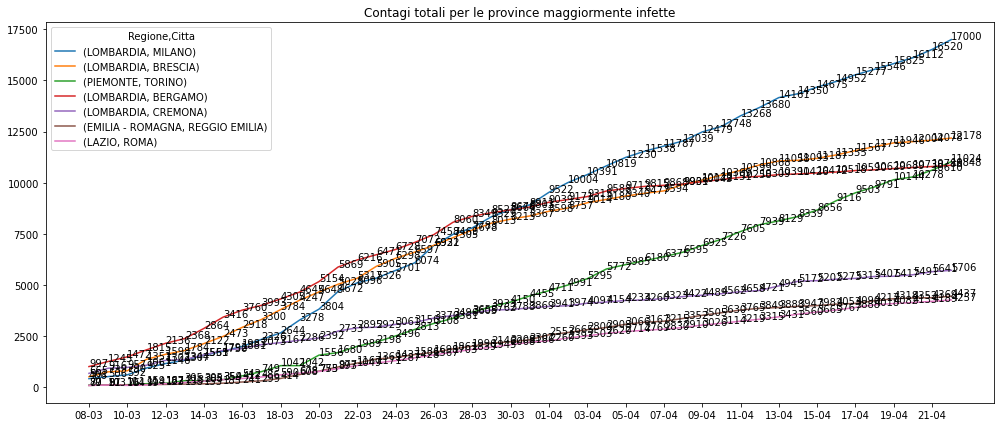

In [21]:
_ = plot_annotate(sorted_by_infections.head(7),'Contagi totali per le province maggiormente infette')

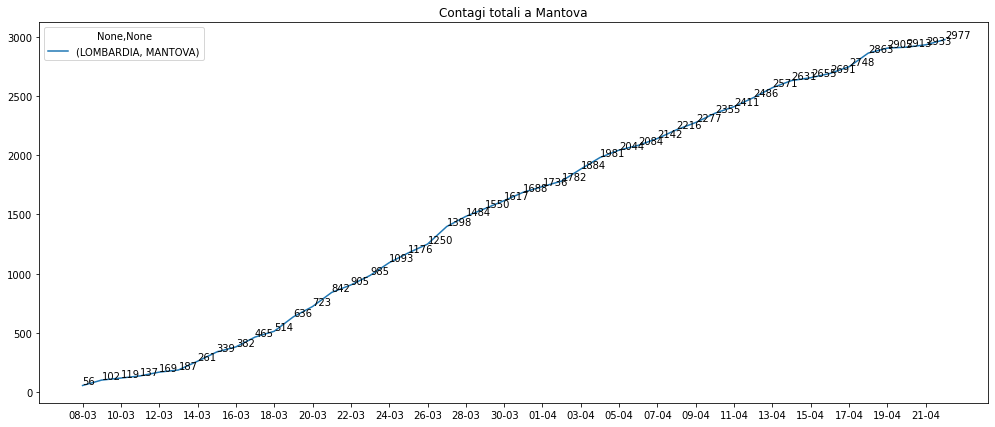

In [22]:
_ = plot_annotate(sorted_by_infections.loc[('LOMBARDIA','MANTOVA')].to_frame().T, 'Contagi totali a Mantova')

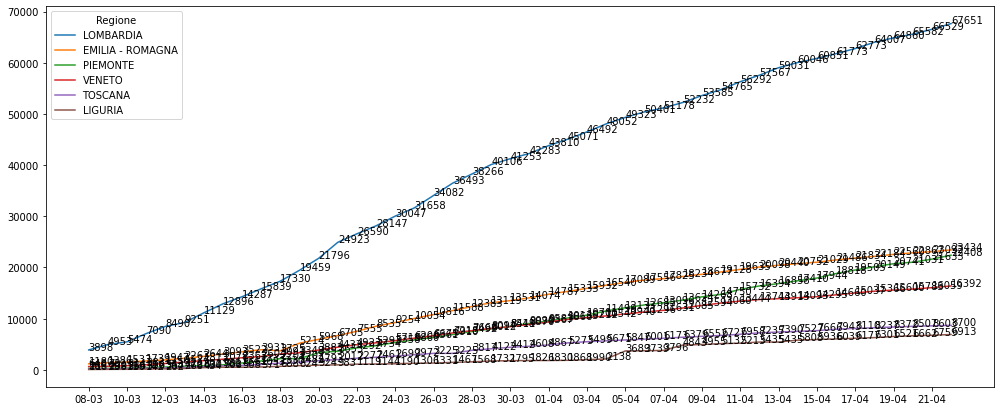

In [23]:
_ = plot_annotate(regioni.head(6))